In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
import nltk
import seaborn as sns
import os
from fuzzywuzzy import fuzz
from itertools import combinations
from datetime import date

In [2]:
!ls '../Dados/SirioLibanes/'

'HSL_Dataset_Covid19_Dicionário de Dados.xlsx'	 hsl_lab_result_1.csv
'HSL Dataset final.Zip'				 hsl_patient_1.csv
 hsl_desfecho_1.csv				 hsl_small_dataset_fapesp.zip


## Lendo datasets

In [3]:
hsl_desfecho = pd.read_csv('../Dados/SirioLibanes/hsl_desfecho_1.csv', sep='|')
hsl_pacientes = pd.read_csv('../Dados/SirioLibanes/hsl_patient_1.csv', sep='|')
hsl_result = pd.read_csv('../Dados/SirioLibanes/hsl_lab_result_1.csv', sep='|')

In [4]:
hsl_result['count'] = 1

In [5]:
hsl_result['DE_EXAME'] = hsl_result['DE_EXAME'].str.replace('[\x81\x93\x9a§\xad´ÂĂĄľŁłŞşŠ]*', "")

In [6]:
hsl_result['DE_EXAME']

0                        Peptideo Natriuretico Tipo B (Bnp)
1                                                      Sdio
2                                                Creatinina
3                                   Hemograma, sangue total
4                                   Hemograma, sangue total
                                ...                        
371352                                     T4L, livre, soro
371353    COVID-19-PCR para SARS-COV-2, Vrios Materiais ...
371354    COVID-19-PCR para SARS-COV-2, Vrios Materiais ...
371355    Deteco de Coronavrus (NCoV-2019) POR PCR (Anat...
371356    Deteco de Coronavrus (NCoV-2019) POR PCR (Anat...
Name: DE_EXAME, Length: 371357, dtype: object

## Clustering exams

In [7]:
hsl_result.groupby(['DE_EXAME']).agg({'count':'sum'})

,count
DE_EXAME,
17 Alfa Hidroxiprogesterona,2
"Acido Ascorbico, plasma",6
Acido Flico,112
"Adenovirus, Sorologia",1
Adenovrus PCR Quantitativo,1
...,...
"cido Metilmalnico, Soro",1
"cido Valprico, Dosagem",1
cido rico,155


In [8]:
df = hsl_result

In [9]:
# Getting all a list with the names of all the exams.
all_exams = df['DE_EXAME'].unique()

In [10]:
# Pairing exames with at least 80% if name similarity according to Levenstein's Distance
pairing_percentage = [ (i, j) for j in all_exams for i in all_exams if fuzz.ratio(i, j) > 80 and i != j]
pairing_percentage

[('Creatinofosfoquinase Cpk-Ck', 'Creatinofosfoquinase - CK-MB'),
 ('Creatinofosfoquinase - CK-MB', 'Creatinofosfoquinase Cpk-Ck'),
 ('Creatino Fosfoquinase (Cpk)', 'Creatinofosfoquinase Cpk-Ck'),
 ('Protena C Reativa, soro', 'Protena C Reativa, plasma'),
 ('Desidrogenase Ltica  ( LDH )', 'Desidrogenase Ltica (DHL/L)'),
 ('Fosfatase Alcalina, soro', 'Fosfatase Alcalina'),
 ('Hemocultura para anaerbios, por maldi-tof, vrios materiais',
  'Hemocultura para aerbios, por maldi-tof, vrios materiais'),
 ('Hemocultura para fungos, por maldi-tof, vrios materiais',
  'Hemocultura para aerbios, por maldi-tof, vrios materiais'),
 ('Hemocultura para aerbios, por maldi-tof, vrios materiais',
  'Hemocultura para anaerbios, por maldi-tof, vrios materiais'),
 ('Hemocultura para fungos, por maldi-tof, vrios materiais',
  'Hemocultura para anaerbios, por maldi-tof, vrios materiais'),
 ('Creatinofosfoquinase Cpk-Ck', 'Creatino Fosfoquinase (Cpk)'),
 ('Urina, Cultura Jato Final', 'Urina, Cultura - Jato Md

In [11]:
aux = []
for i, j in pairing_percentage:
    aux.append(i)
    aux.append(j)

### Preparation for clustering...
We will first create our adjacency matrix through this list comprehension and rename it to the variable ```X```. This variable will be used in all the steps following.

**Important**: The function fuzz.ratio returns the **similarity** degree between two strings according to Levenstein's Distance, but we want to analyze the **distance** between these strings, so we're going to invert our values by subtracting from 100 each Levenstein's Distance value obtained. So, in the end, **the lower the value, the closer are the strings**.

In [12]:
adj_matrix = np.array([ np.array([100 - fuzz.ratio(i, j) for j in all_exams]) for i in all_exams])
X = adj_matrix

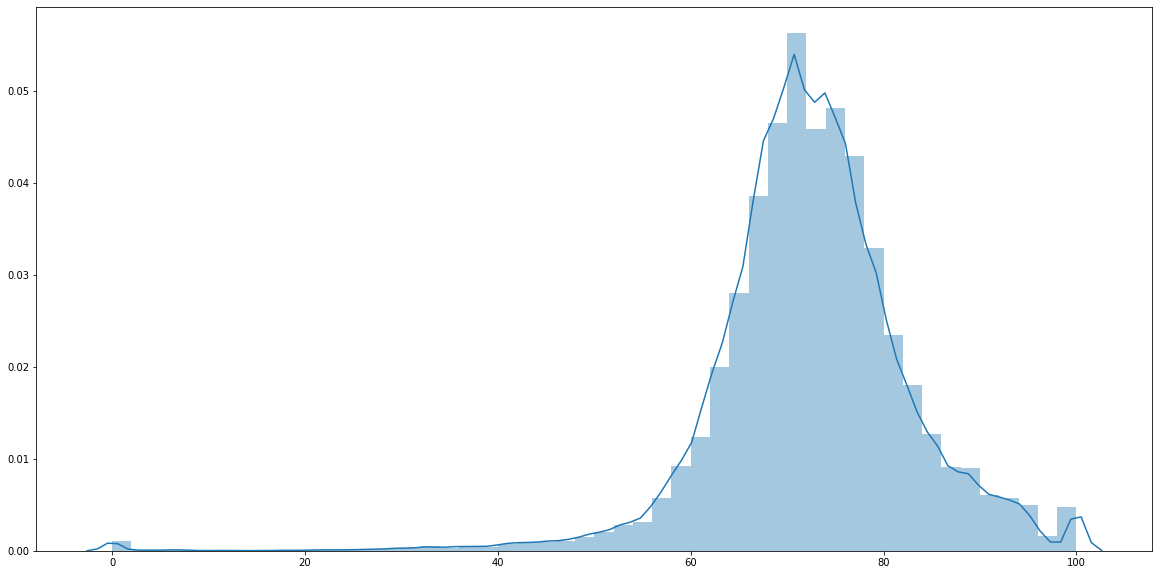

In [13]:
plt.rcParams['figure.figsize'] = 20, 10
distplot = sns.distplot(X);
distplot = distplot.get_figure()
distplot.savefig("adj_matrix_histogram")

### Multidimensional Scaling (MDS)
Plotting our strings in a 2D space.

In [14]:
embedding = MDS(n_components=2)
mds = embedding.fit_transform(X)

/home/joaopedromattos/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


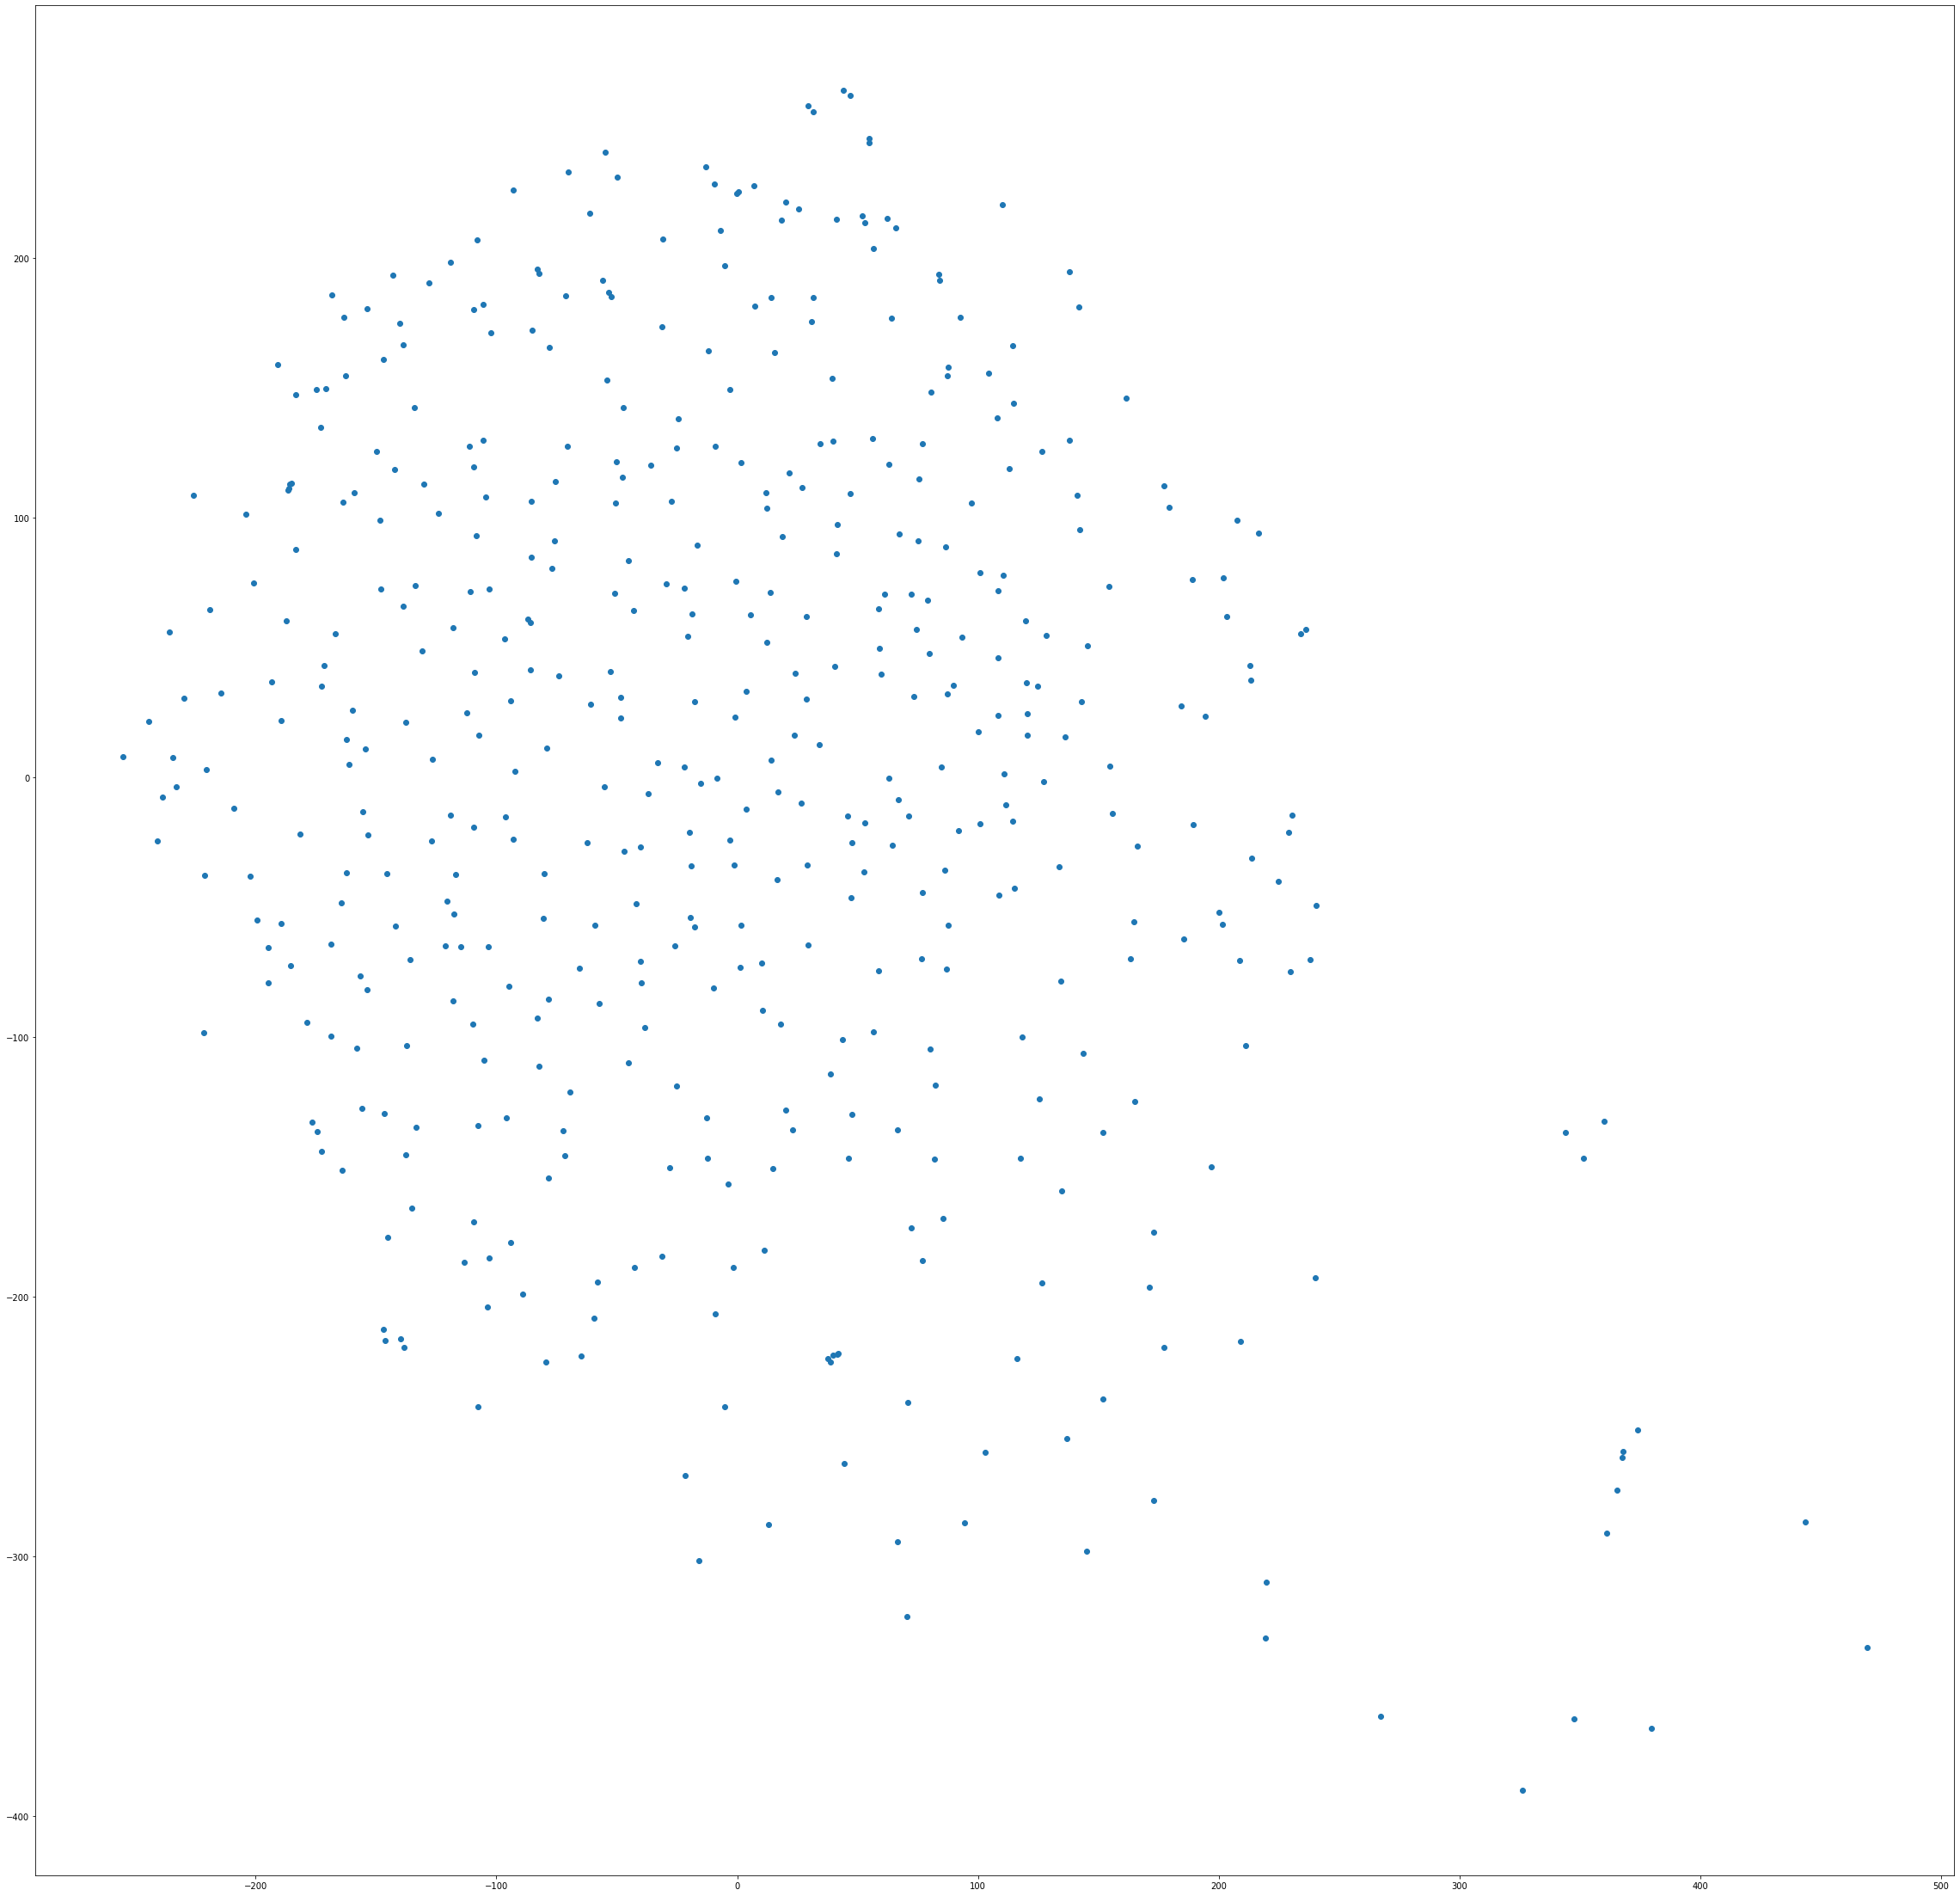

In [15]:
plt.rcParams['figure.figsize'] = 40, 40
plt.scatter(x=mds[:, 0], y=mds[:, 1])
plt.savefig('MDS')

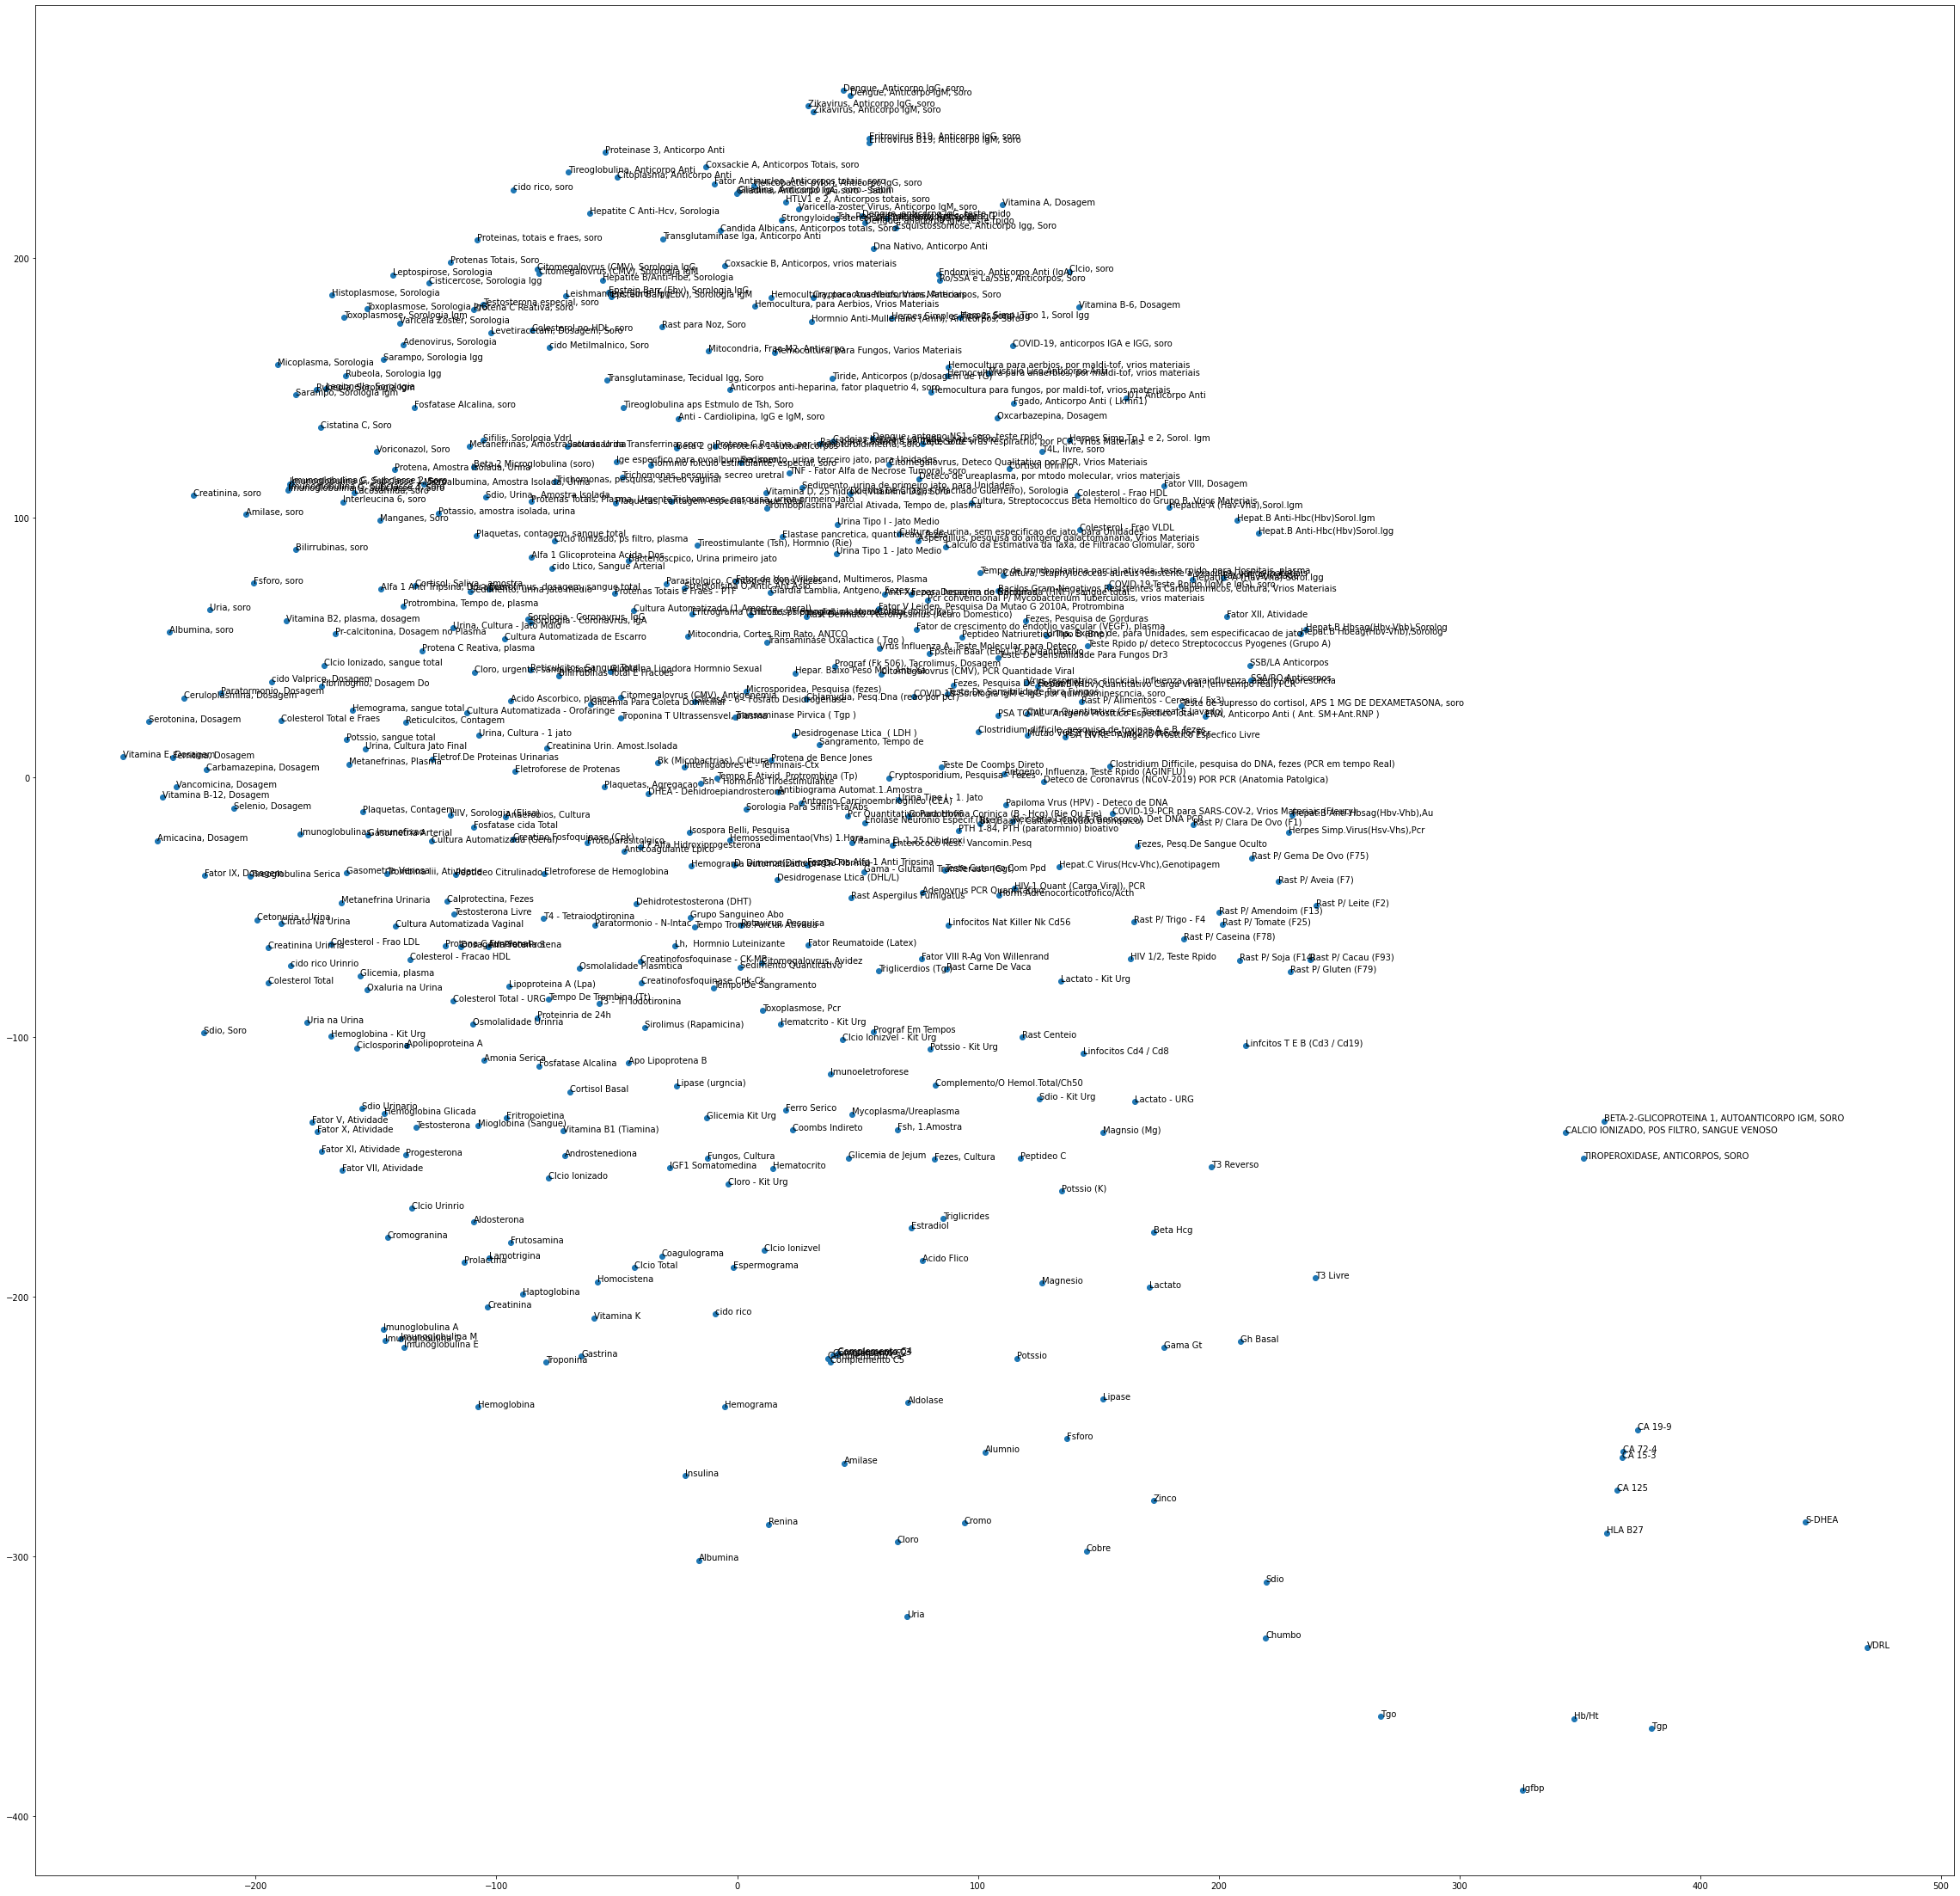

In [16]:
plt.rcParams['figure.figsize'] = 40, 40
plt.scatter(x=mds[:, 0], y=mds[:, 1])
for i, point in enumerate(mds):
    plt.annotate(all_exams[i], (point[0], point[1]))
plt.savefig('MDS_annotated')

### Clustering...

In [17]:
np.histogram(X)

(array([   604,     76,    306,    934,   2378,  10516,  66550, 103464,
         33048,  10608]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]))

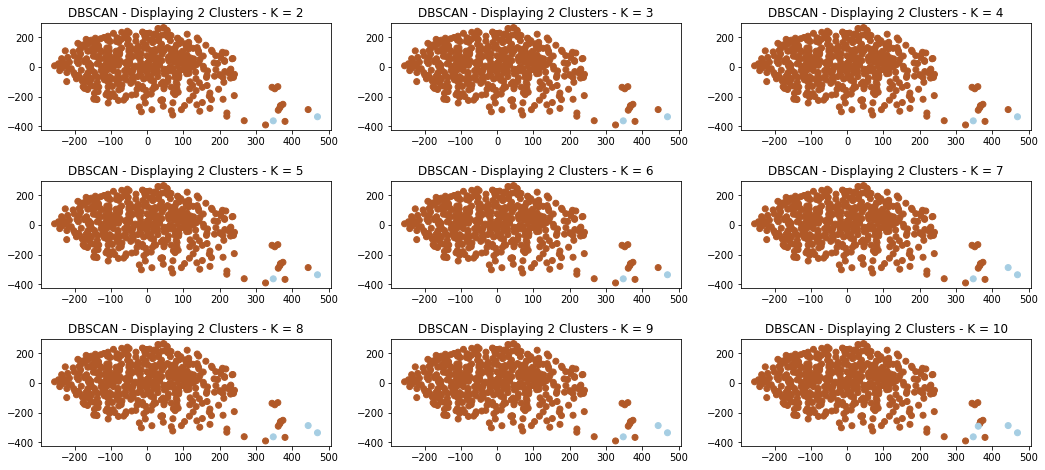

In [62]:
# Preparing our subplots..
plt.rcParams["figure.figsize"] = (15,7)
fig, axs = plt.subplots(3, 3)
fig.tight_layout(pad=3)

# A list with all values of K we're going to test...
ks = np.arange(2, 11)
cluster_number = []
count = 0

for i in range(3):
    for j in range(3):
        db = DBSCAN(eps=X.mean(), min_samples=ks[count], metric='precomputed').fit(adj_matrix)
        y_pred = db.fit_predict(X)
        
        # Plotting...
        axs[i][j].scatter(mds[:, 0], mds[:, 1] ,c=y_pred, cmap='Paired')
        axs[i][j].set_title(f"DBSCAN - Displaying {len(np.unique(db.labels_))} Clusters - K = {ks[count]}");
        cluster_number.append(len(np.unique(db.labels_)))
        
        count += 1
plt.savefig('DBSCAN_k_plot')

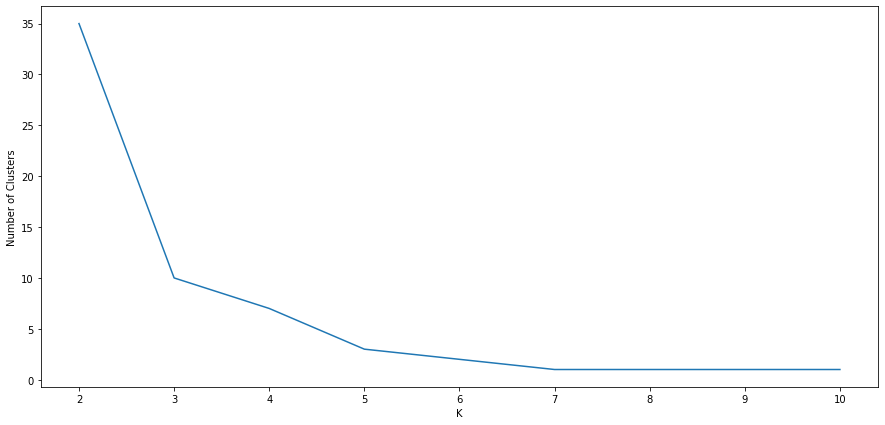

In [22]:
plt.xlabel("K")
plt.ylabel("Number of Clusters")
plt.plot(ks, cluster_number)
plt.savefig('number_of_cluster_by_k')

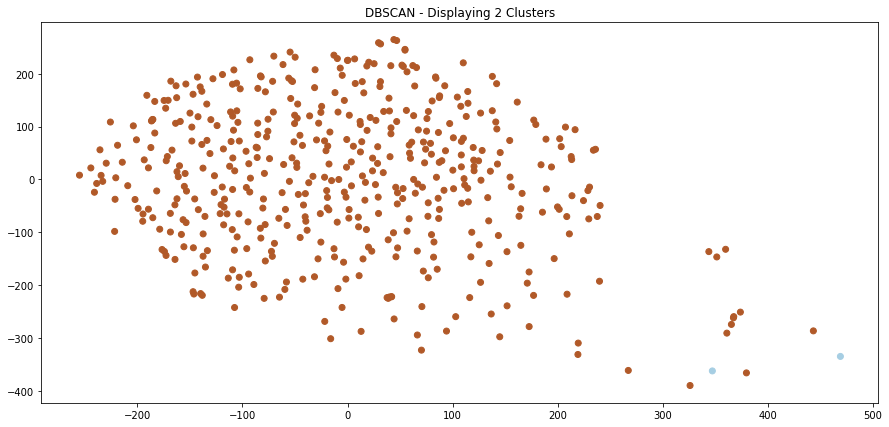

In [71]:
db = DBSCAN(eps=X.mean(), min_samples=2, metric='precomputed').fit(adj_matrix);

plt.rcParams["figure.figsize"] = (15,7);

y_pred = db.fit_predict(X);
plt.scatter(mds[:, 0], mds[:, 1] ,c=y_pred, cmap='Paired');

plt.title(f"DBSCAN - Displaying {len(np.unique(db.labels_))} Clusters");
plt.savefig('DBSCAN_K_EQUALS_2')

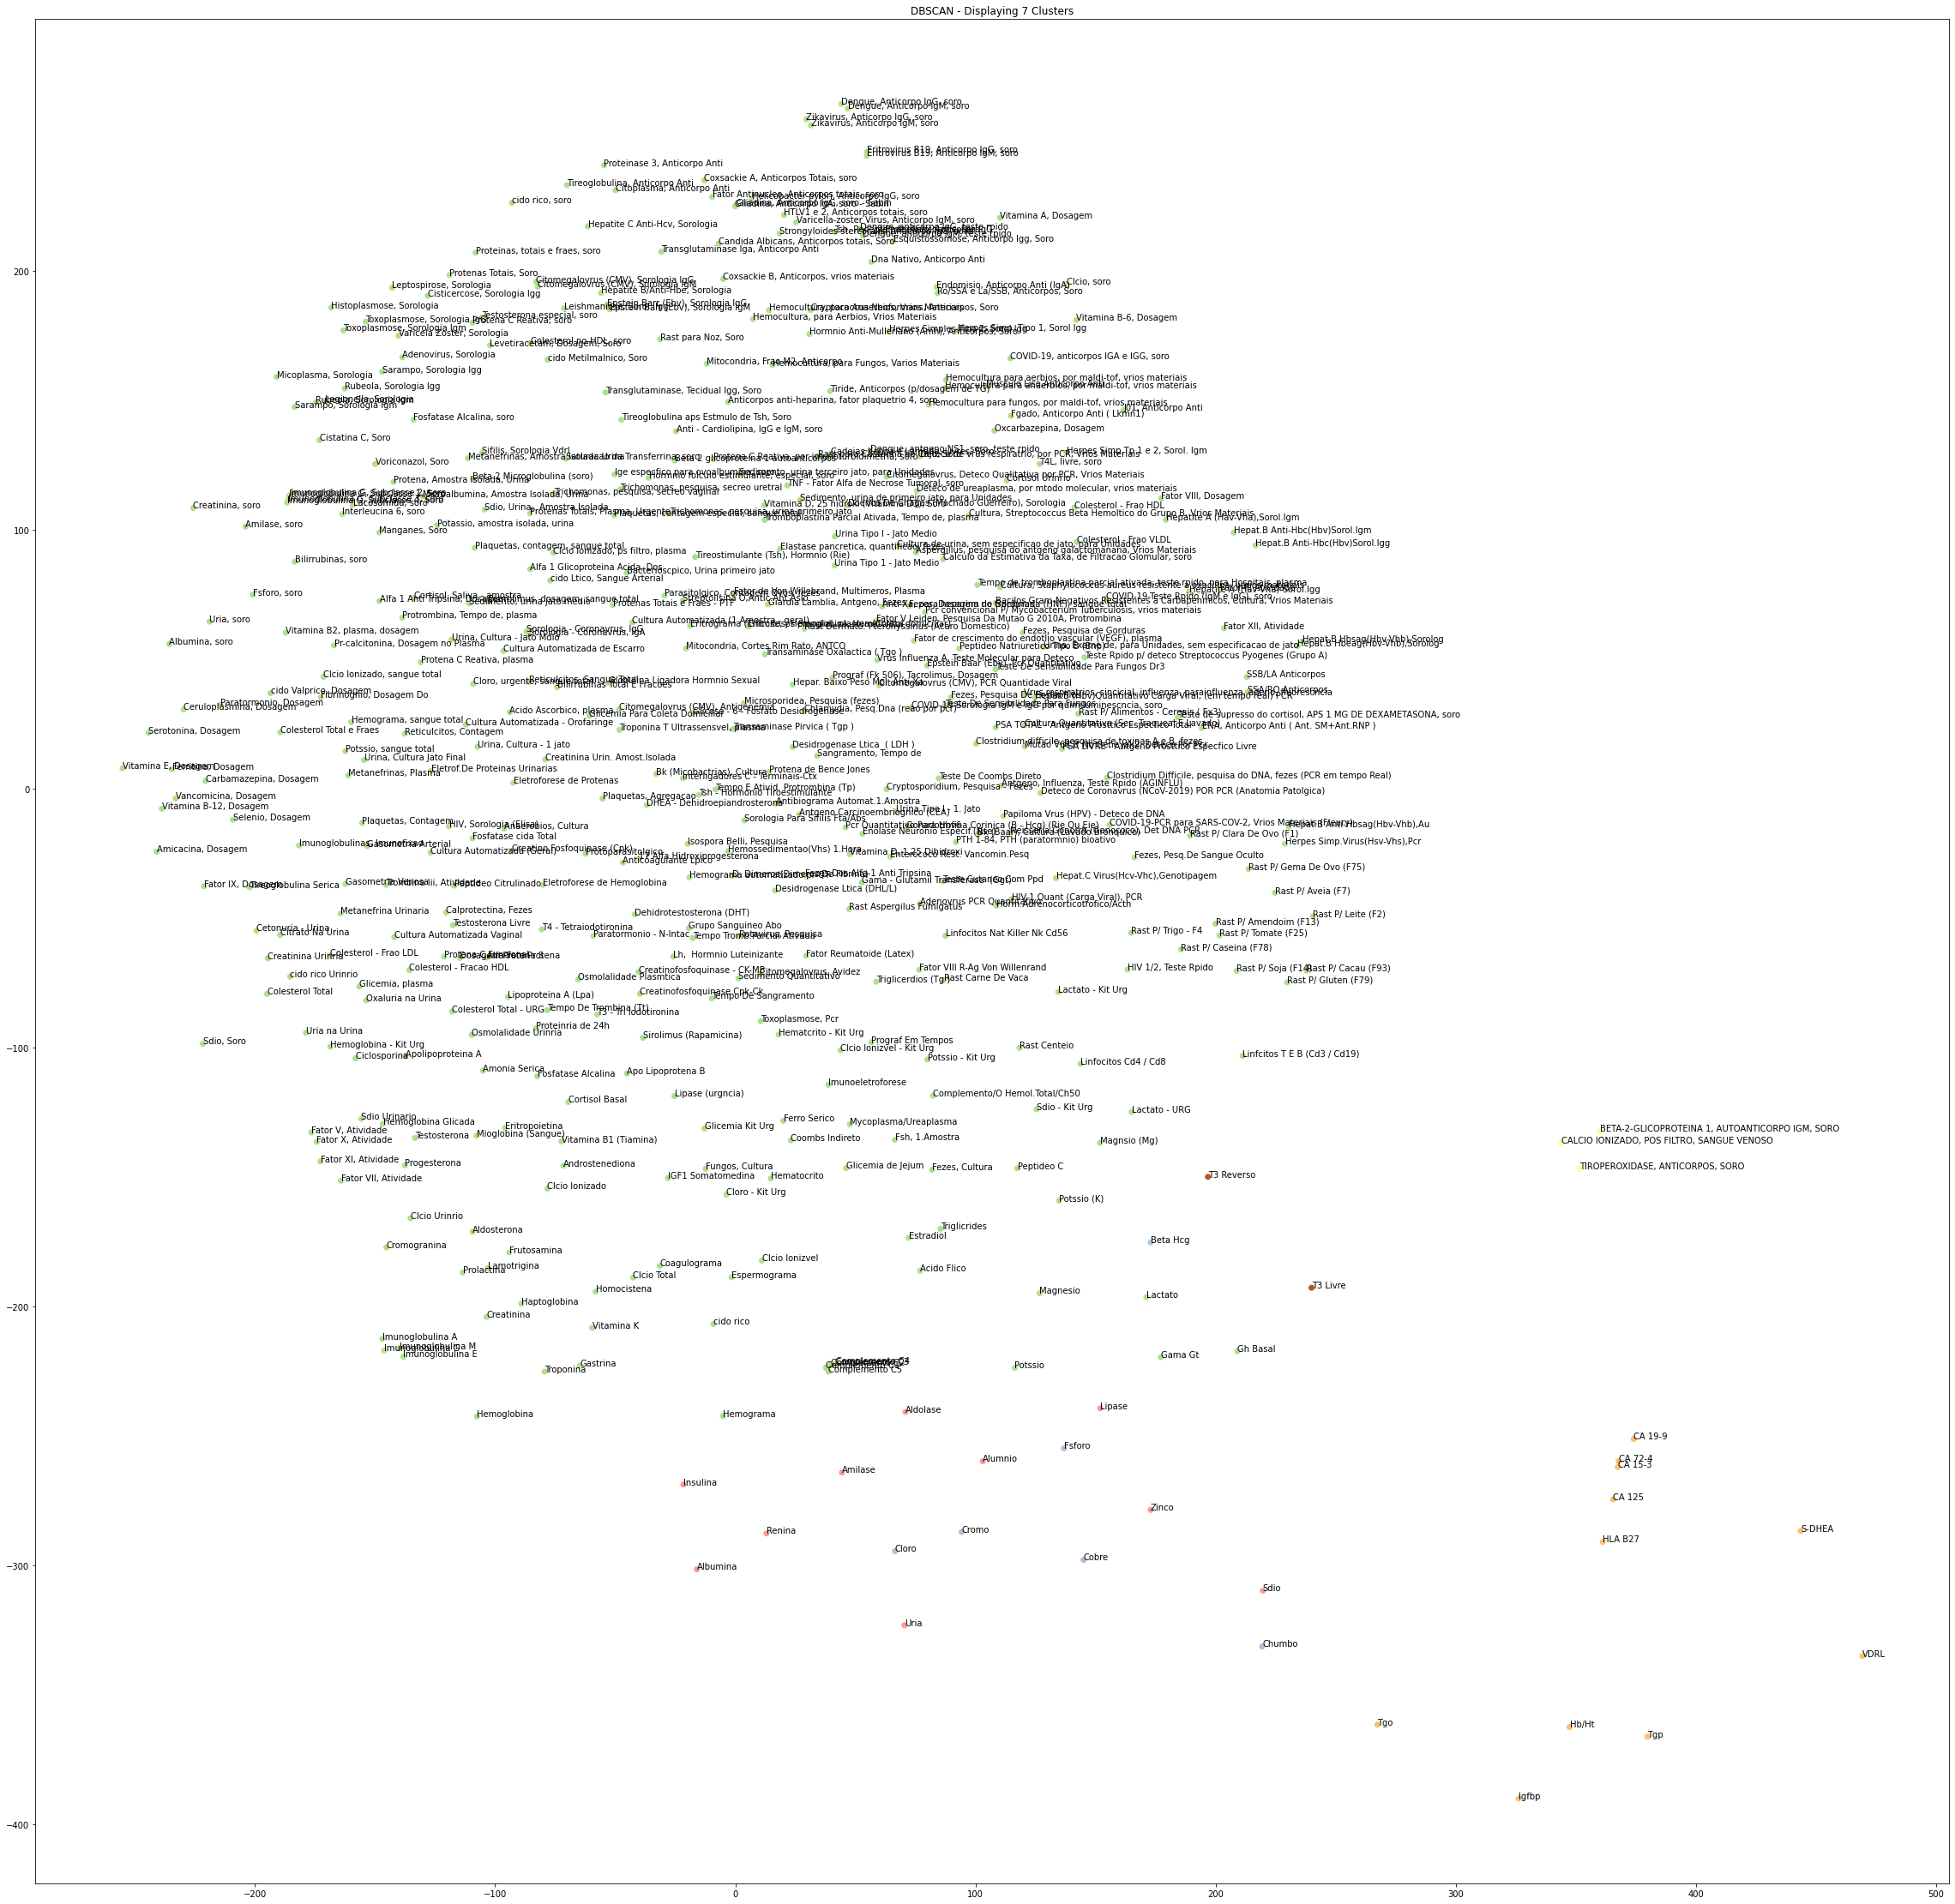

In [25]:
db = DBSCAN(eps=200, min_samples=2).fit(adj_matrix);

# plt.rcParams["figure.figsize"] = (15,7);
plt.rcParams['figure.figsize'] = 40, 40

y_pred = db.fit_predict(X_test);
plt.scatter(mds[:, 0], mds[:, 1] ,c=y_pred, cmap='Paired');

for i, point in enumerate(mds):
    plt.annotate(all_exams[i], (point[0], point[1]))

plt.title(f"DBSCAN - Displaying {len(np.unique(db.labels_))} Clusters");
plt.savefig('DBSCAN_K_EQUALS_2')

In [86]:
import altair as alt
from vega_datasets import data
# cars = data.cars.url
# input_dropdown = alt.binding_select(options=np.unique(db.labels_))
# selection = alt.selection_single(fields=['Clusters'], bind=input_dropdown, name='Country of ')
color = alt.condition(selection,
                    alt.Color('Origin:N', legend=None),
                    alt.value('lightgray'))

alt.Chart(cars).mark_point().encode(
    x='Horsepower:Q',
    y='Miles_per_Gallon:Q',
    color='Origin:N',
    tooltip='Name:N'
).add_selection(
    selection
).transform_filter(
    selection
)



alt.Chart(...)